In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

C:\Users\Damianus Deni\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Import Data

In [51]:
df = pd.read_csv("data/train.csv", index_col="ID")
df.head()

,GRE,TOEFL,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
ID,,,,,,,,
250,321,111,3,3.5,4.0,8.83,1,0.77
434,316,111,4,4.0,5.0,8.54,0,0.71
20,303,102,3,3.5,3.0,8.50,0,0.62
323,314,107,2,2.5,4.0,8.27,0,0.72
333,308,106,3,3.5,2.5,8.21,1,0.75


#### plot missing values

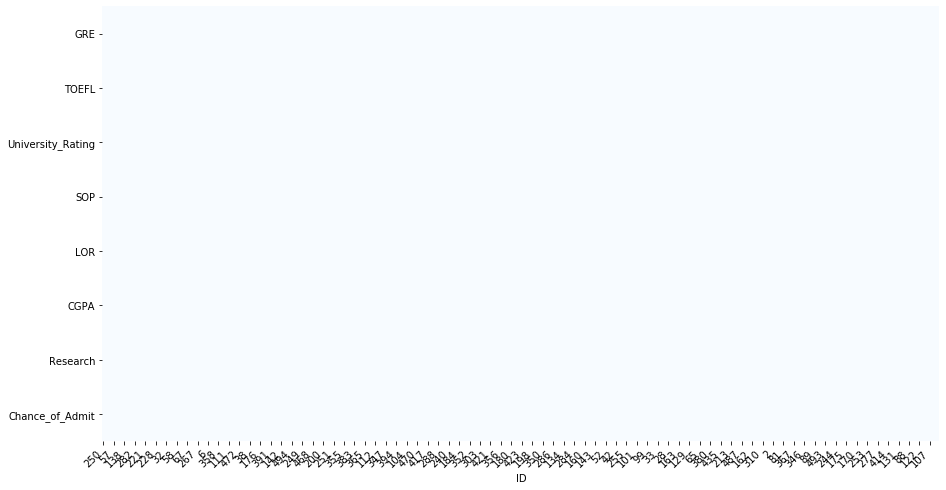

In [3]:
plot_missing_value(df)

#### Feature Engineering

In [52]:
# # Encoding University Rating
# df.University_Rating = df.University_Rating.map({
#     1: "extremely bad", 
#     2: "bad",
#     3: "good", 
#     4: "very good", 
#     5: "excellent"
# })

In [53]:
df.head()

,GRE,TOEFL,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
ID,,,,,,,,
250,321,111,3,3.5,4.0,8.83,1,0.77
434,316,111,4,4.0,5.0,8.54,0,0.71
20,303,102,3,3.5,3.0,8.50,0,0.62
323,314,107,2,2.5,4.0,8.27,0,0.72
333,308,106,3,3.5,2.5,8.21,1,0.75


# Dataset Splitting

In [54]:
X = df.drop(columns="Chance_of_Admit")
y = df.Chance_of_Admit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((320, 7), (80, 7), (320,), (80,))

# Training

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

C:\Users\Damianus Deni\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Damianus Deni\Miniconda3\envs\jcopml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [55]:
df.head()

,GRE,TOEFL,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
ID,,,,,,,,
250,321,111,3,3.5,4.0,8.83,1,0.77
434,316,111,4,4.0,5.0,8.54,0,0.71
20,303,102,3,3.5,3.0,8.50,0,0.62
323,314,107,2,2.5,4.0,8.27,0,0.72
333,308,106,3,3.5,2.5,8.21,1,0.75


In [19]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

### RANDOMIZED SEARCH: RF v2 BEST SCORE

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE", "TOEFL", "SOP", "LOR", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University_Rating", "Research"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   27.5s finished


{'algo__max_depth': 80, 'algo__max_features': 0.5577136220482326, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 122}
0.8752626632301754 0.8014859291745058 0.8231099331088619


### RANDOMIZED SEARCH: RF v8

In [64]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE", "TOEFL", "SOP", "LOR", "CGPA", "University_Rating"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Research"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=60, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   57.6s finished


{'algo__max_depth': 46, 'algo__max_features': 0.4756699028339012, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 196}
0.8717781600790467 0.8018660935102457 0.8144866387440773


In [56]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

### RANDOMIZED SEARCH: RF v7

In [57]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE", "TOEFL", "SOP", "LOR", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University_Rating", "Research"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

rfparameter = {'algo__n_estimators': range(100,200),
 'algo__max_depth': range(63, 81),
 'algo__max_features': [0.45, 0.6],
 'algo__min_samples_leaf': [4, 6]}

model = RandomizedSearchCV(pipeline, rfparameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   29.6s finished


{'algo__n_estimators': 155, 'algo__min_samples_leaf': 6, 'algo__max_features': 0.45, 'algo__max_depth': 74}
0.866323471153701 0.802467079663444 0.8193716221986911


### RANDOMIZED SEARCH: RF v6 4th best score

In [44]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE", "TOEFL", "SOP", "LOR", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University_Rating", "Research"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   28.8s finished


{'algo__max_depth': 46, 'algo__max_features': 0.4756699028339012, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 196}
0.8742090314450554 0.8024970885773269 0.8211592739194714


### RANDOMIZED SEARCH: RF v5 2n best score

In [29]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [37]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE", "TOEFL", "SOP", "LOR", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University_Rating", "Research"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])


rfparameter = {'algo__n_estimators': range(120,196),
 'algo__max_depth': range(40, 80),
 'algo__max_features': [0.3, 0.4, 0.5, 0.6, 0.7],
 'algo__min_samples_leaf': range(3, 8)}


model = RandomizedSearchCV(pipeline, rfparameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   29.0s finished


{'algo__n_estimators': 187, 'algo__min_samples_leaf': 6, 'algo__max_features': 0.5, 'algo__max_depth': 65}
0.8659596242653081 0.8009612623374699 0.8265240728123382


### RANDOMIZED SEARCH: RF v4 polynomial failed

In [28]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=3), ["GRE", "TOEFL", "SOP", "LOR", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University_Rating", "Research"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

# parameter


model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   25.1s finished


{'algo__max_depth': 26, 'algo__max_features': 0.3607763076223912, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 141, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.9270383910535411 0.8024904611169057 0.7896314305817781


### GRID SEARCH: RF v3 failed

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE", "TOEFL", "SOP", "LOR", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University_Rating", "Research"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])


model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   42.1s finished


{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9720332515007792 0.8011476590541827 0.7785931250623562


#### modifying data label on data test 

In [47]:
# df_submit = pd.read_csv("data/test.csv", index_col="ID")

In [48]:
# # Encoding University Rating
# df_submit.University_Rating = df.University_Rating.map({
#     1: "extremely bad", 
#     2: "bad",
#     3: "good", 
#     4: "very good", 
#     5: "excellent"
# })

# Submission

In [62]:
def submit(model, filename="deni__v8.csv"):
    df_submit['Chance_of_Admit'] = model.predict(df_submit)
    df_submit[['Chance_of_Admit']].to_csv(filename, index_label='ID')

In [63]:
submit(model, filename="deni__v8.csv")

C:\Users\Damianus Deni\Miniconda3\envs\jcopml\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


# Notes on Final Score

```
2nd best score
v5. {'algo__n_estimators': 187, 'algo__min_samples_leaf': 6, 'algo__max_features': 0.5, 'algo__max_depth': 65}
0.8659596242653081 0.8009612623374699 0.8265240728123382
- cv=3, n_iter=50, random, 
rfparameter = {'algo__n_estimators': range(120,196),
 'algo__max_depth': range(40, 80),
 'algo__max_features': [0.3, 0.4, 0.5, 0.6, 0.7],
 'algo__min_samples_leaf': range(3, 8)}

3rd best score
v1. {'algo__max_depth': 46, 'algo__max_features': 0.4756699028339012, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 196}
0.8741429363364741 0.7980725181410776 0.816984784266618 
- cv=4, n_iter=50, random

4th best score
v6. {'algo__max_depth': 46, 'algo__max_features': 0.4756699028339012, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 196}
0.8742090314450554 0.8024970885773269 0.8211592739194714


v7. 0.866323471153701 0.802467079663444 0.8193716221986911
v8. {'algo__max_depth': 46, 'algo__max_features': 0.4756699028339012, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 196}
0.8717781600790467 0.8018660935102457 0.8144866387440773

v3. {'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9720332515007792 0.8011476590541827 0.7785931250623562
- cv3, grid failed

v4. {'algo__max_depth': 26, 'algo__max_features': 0.3607763076223912, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 141, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.9270383910535411 0.8024904611169057 0.7896314305817781
- cv3, random, poly failed
```